In [1]:
"""
BLEU and ROUGE Evaluation for a GPT-2 Conversation Prediction Model

Steps:
1) Load CSV from user path
2) Build partial->remainder pairs
3) Load fine-tuned GPT-2 model
4) Generate predicted remainder for each partial snippet
5) Compare predicted vs. reference with BLEU and ROUGE
6) Visualize the distribution of sample-level BLEU or ROUGE
"""

# If needed:
# !pip install nltk evaluate rouge-score
# Also, you might need to download NLTK data for BLEU if not present:
# import nltk
# nltk.download('punkt')


'\nBLEU and ROUGE Evaluation for a GPT-2 Conversation Prediction Model\n\nSteps:\n1) Load CSV from user path\n2) Build partial->remainder pairs\n3) Load fine-tuned GPT-2 model\n4) Generate predicted remainder for each partial snippet\n5) Compare predicted vs. reference with BLEU and ROUGE\n6) Visualize the distribution of sample-level BLEU or ROUGE\n'

In [2]:
# !pip install evaluate

In [3]:
# =============================================
# 1) Imports
# =============================================
import os
import math
import pandas as pd
import torch

# We'll use NLTK for BLEU
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# We'll use evaluate for ROUGE
import evaluate

# Torch, Transformers
from torch.utils.data import Dataset
from transformers import GPT2LMHeadModel, GPT2Tokenizer

import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device in use:", device)


c:\Users\DELL\anaconda3\envs\ai-backend\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\DELL\anaconda3\envs\ai-backend\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(



Device in use: cpu


In [4]:
# =============================================
# 2) CSV Path & Model Dir
# =============================================
csv_path = r"C:/Users/DELL/Desktop/VOIP_Phishing_Attacks/Repos/convoPredict/conversation-prediction/testdataset.csv"
model_dir = r"C:/Users/DELL/Desktop/VOIP_Phishing_Attacks/Repos/convoPredict/conversation-prediction/research/3. MidEvaluation/fineTune/gpt2_conversation_predict_model"

partial_ratio = 0.5  # <--- param: how large partial snippet is vs remainder
print("CSV Path:", csv_path)
print("Model Dir:", model_dir)


CSV Path: C:/Users/DELL/Desktop/VOIP_Phishing_Attacks/Repos/convoPredict/conversation-prediction/testdataset.csv
Model Dir: C:/Users/DELL/Desktop/VOIP_Phishing_Attacks/Repos/convoPredict/conversation-prediction/research/3. MidEvaluation/fineTune/gpt2_conversation_predict_model


In [5]:
# =============================================
# 3) Build partial->remainder from CSV
# =============================================
def build_partial_remainder(csv_path, partial_ratio=0.5):
    """
    Groups lines by conversation ID, sorts by step,
    then splits each conversation into partial vs remainder.
    Returns a list of (partial_str, remainder_str).
    """
    df = pd.read_csv(csv_path)
    pairs = []
    for convo_id, group in df.groupby("CONVERSATION_ID"):
        group_sorted = group.sort_values("CONVERSATION_STEP")
        texts = group_sorted["TEXT"].tolist()
        if len(texts) < 2:
            continue
        cutoff = max(1, int(len(texts)*partial_ratio))
        partial_list = texts[:cutoff]
        remainder_list= texts[cutoff:]
        partial_str = "\n".join(partial_list).strip()
        remainder_str= "\n".join(remainder_list).strip()
        if partial_str and remainder_str:
            pairs.append((partial_str, remainder_str))
    return pairs

pairs = build_partial_remainder(csv_path, partial_ratio=partial_ratio)
print(f"Number of partial->remainder pairs: {len(pairs)}")
if pairs:
    print("Sample pair:\nPartial:", pairs[0][0], "\nRemainder:", pairs[0][1])


Number of partial->remainder pairs: 29
Sample pair:
Partial: Hello, I need help with my bank account.
Sure, I can help you with that. Can you please provide your account number?
My account number is 12345678.
Thank you. Can you also provide your PIN?
My PIN is 1234.
Thank you. Please hold on while I verify your information.
Okay, I'll wait. 
Remainder: Wait, how do I know this is really my bank?
I assure you, this is a legitimate call. You can check the number we are calling from.
Alright, the number does match my bank's number.
Great, now please provide your account number and PIN.
Here is my account number: 12345678 and my PIN: 1234.
Thank you. Your account is now secure.
I'm glad to hear that. Thank you for your help.
You're welcome. Have a nice day.


In [6]:
# =============================================
# 4) Load GPT-2 Fine-Tuned Model
# =============================================
print("Loading tokenizer and model from:", model_dir)
tokenizer = GPT2Tokenizer.from_pretrained(model_dir)
# GPT-2 typically no pad token => let's set pad_token = eos_token
tokenizer.pad_token = tokenizer.eos_token

model = GPT2LMHeadModel.from_pretrained(model_dir)
model.to(device)
model.eval()
print("Model loaded.")


Loading tokenizer and model from: C:/Users/DELL/Desktop/VOIP_Phishing_Attacks/Repos/convoPredict/conversation-prediction/research/3. MidEvaluation/fineTune/gpt2_conversation_predict_model


Model loaded.


In [7]:
# =============================================
# 5) Generate Predicted Remainder from Partial
# =============================================
def generate_remainder(model, tokenizer, partial_text, max_new_tokens=50):
    inputs = tokenizer(partial_text, return_tensors="pt").to(device)
    with torch.no_grad():
        output_ids = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens, 
            do_sample=False, 
            pad_token_id=tokenizer.eos_token_id  # avoid errors for pad
        )
    full_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    # The entire text includes partial + newly generated remainder
    # If you want to isolate the remainder portion, you can do some substring logic
    return full_text

# We'll define a function that tries to extract the part after the partial 
# to compare with the reference remainder. This is optional.
def extract_model_remainder(full_gen, partial_text):
    """
    Attempt to get the substring of full_gen that appears after partial_text
    for direct comparison with the reference remainder.
    We'll do a naive approach: find partial_text inside full_gen and take what's after.
    """
    idx = full_gen.find(partial_text)
    if idx == -1:
        # partial_text not found exactly, fallback
        return full_gen
    else:
        # remainder is what's after partial_text
        after_part = full_gen[idx+len(partial_text):].strip()
        return after_part


In [8]:
# !pip install rouge_score

In [9]:
# =============================================
# 6) Evaluate with BLEU and ROUGE
# =============================================

# We'll define NLTK BLEU with sentence_bleu each sample
# We'll define a ROUGE evaluator using `evaluate.load("rouge")`

rouge_evaluator = evaluate.load("rouge")

# We'll store sample-level BLEU and ROUGE-L
bleu_scores = []
rougeL_scores = []

# We'll also store references vs predictions for a batch approach to ROUGE
references = []
predictions = []

# We'll define a smoothing function for BLEU
smoother = nltk.translate.bleu_score.SmoothingFunction().method1

print("Evaluating model on partial->remainder dataset...")

for i, (partial, reference_remainder) in enumerate(pairs):
    # 1) Generate entire text from partial
    gen_text = generate_remainder(model, tokenizer, partial, max_new_tokens=100)
    # 2) Extract the remainder portion from the generation
    predicted_remainder = extract_model_remainder(gen_text, partial)

    # For BLEU, we do sentence_bleu(references, hypothesis), references must be list of tokens
    ref_tokens = nltk.word_tokenize(reference_remainder.lower())
    hyp_tokens = nltk.word_tokenize(predicted_remainder.lower())

    # If reference is empty or partial is empty, skip or handle carefully
    if len(ref_tokens)==0 or len(hyp_tokens)==0:
        bleu = 0.0
    else:
        bleu = sentence_bleu(
            [ref_tokens], 
            hyp_tokens, 
            smoothing_function=smoother
        )
    bleu_scores.append(bleu)

    # For ROUGE, we can store them for batch evaluate or do single-sample approach
    references.append(reference_remainder)
    predictions.append(predicted_remainder)

print("Computing ROUGE on the entire set...")

# compute ROUGE metrics on all references/predictions
# evaluate library expects lists
rouge_results = rouge_evaluator.compute(predictions=predictions, references=references)
# typically it includes 'rouge1', 'rouge2', 'rougeL', 'rougeLsum'
rougeL = rouge_results["rougeL"]  # F-measure for ROUGE-L
print("ROUGE results:", rouge_results)

# We'll store sample-level ROUGE-L by computing individually if we want
# for a distribution. But the evaluate library approach is standard for an average.

# So we do have a single "rougeL" for the entire corpus. If you want sample-level:
# you'd do something like:
# single_result = rouge_evaluator.compute(predictions=[predicted_remainder], references=[reference_remainder])

# We'll just store the final corpus-level rougeL in rougeL_scores
# or we skip sample-level distribution approach for ROUGE in this example
rougeL_scores = rougeL  # corpus-level

avg_bleu = np.mean(bleu_scores)
print(f"\nAverage BLEU on test set = {avg_bleu:.4f}")
print(f"ROUGE-L F1 (corpus-level) = {rougeL_scores:.4f}")


Evaluating model on partial->remainder dataset...
Computing ROUGE on the entire set...
ROUGE results: {'rouge1': 0.15045413527282825, 'rouge2': 0.012404530591411188, 'rougeL': 0.11800321353720708, 'rougeLsum': 0.14025164306548576}

Average BLEU on test set = 0.0135
ROUGE-L F1 (corpus-level) = 0.1180


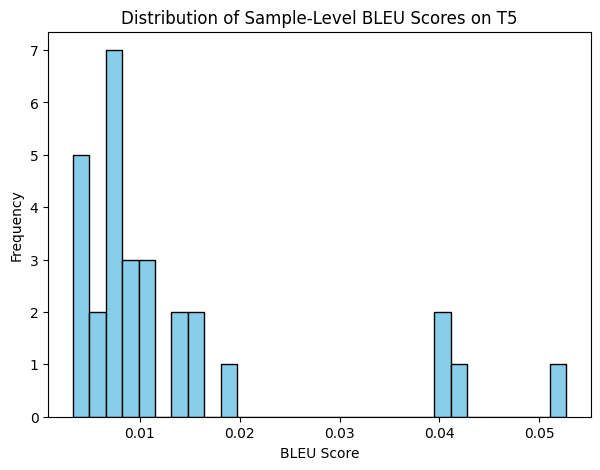

In [10]:
# =============================================
# 7) Visualize the BLEU distribution
# =============================================
plt.figure(figsize=(7,5))
plt.hist(bleu_scores, bins=30, color="skyblue", edgecolor="black")
plt.title("Distribution of Sample-Level BLEU Scores on T5")
plt.xlabel("BLEU Score")
plt.ylabel("Frequency")
plt.show()